<a href="https://colab.research.google.com/github/Abdullah-Al-Arafat/CAP-5610-Machine-Learning/blob/master/ML_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 12:09:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c17::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   148MB/s    in 0.4s    

2019-04-18 12:09:22 (148 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects

from keras import layers,models,optimizers
from keras.applications import VGG19
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


## Necessary files for Problem-3 and Problem-4

from keras import backend as K
from google.colab import files
from google.colab.patches import cv2_imshow
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2

Using TensorFlow backend.


In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

**Problem 1**

In [4]:
## we load the pre-trained model
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 2s 0us/step


In [0]:

# We need to freeze the pre-trained parameters of our model(which is VGG19 model)
conv_base.trainable = False

# We add some fully connected layers to our pretrained model
mod = conv_base.output
mod=layers.Flatten()(mod)
mod=layers.Dense(256, activation='relu')(mod)


# Output layer
mod = layers.Dense(1, activation='sigmoid')(mod)
model = models.Model(inputs=[conv_base.input], outputs=[mod])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

## Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

## We don't do the Data augmentation for validation dataset(except normalization)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Compile Model
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-4), 
    metrics=['acc'])

# Train the network
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 34s 339ms/step - loss: 0.7514 - acc: 0.4990 - val_loss: 0.6964 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 26s 261ms/step - loss: 0.6981 - acc: 0.5335 - val_loss: 0.6526 - val_acc: 0.7030
Epoch 3/20
100/100 [==============================] - 25s 251ms/step - loss: 0.6876 - acc: 0.5200 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/20
100/100 [==============================] - 25s 251ms/step - loss: 0.7132 - acc: 0.4870 - val_loss: 0.8700 - val_acc: 0.5000
Epoch 5/20
100/100 [==============================] - 26s 258ms/step - loss: 0.6325 - acc: 0.6440 - val_loss: 0.4801 - val_acc: 0.7760
Epoch 6/20
100/100 [==============================] - 26s 257ms/step - loss: 0.5513 - acc: 0.7160 - val_loss: 0.4603 - val_acc: 0.7590
Epoch 7/20
100/100 [==============================] - 26s 

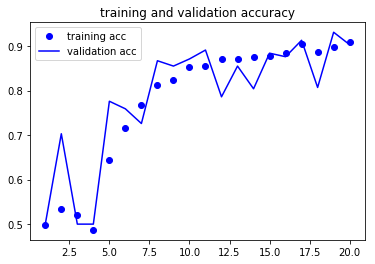

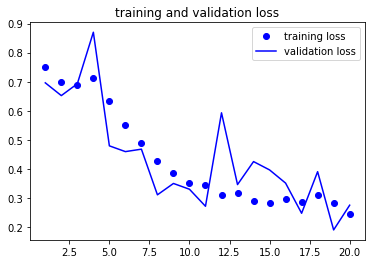

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

## For plotting training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()


## For plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [9]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

model_fname = 'cats_and_dogs_small_Feat_extraction.h5' 
model.save(model_fname)

Validation loss: 0.2675673335790634
Validation accuracy: 0.8980000019073486


**Problem 2**

In [0]:

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block2_conv1':
    set_trainable = True
  if layer.name == 'block4_conv1':
    set_trainable = True
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [11]:
# Compile the Model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# Train the model for fine tuning
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 25s 246ms/step - loss: 0.1502 - acc: 0.9470 - val_loss: 0.2739 - val_acc: 0.9420
Epoch 2/10
100/100 [==============================] - 23s 229ms/step - loss: 0.1206 - acc: 0.9585 - val_loss: 0.1793 - val_acc: 0.9570
Epoch 3/10
100/100 [==============================] - 23s 228ms/step - loss: 0.1248 - acc: 0.9555 - val_loss: 0.2334 - val_acc: 0.9490
Epoch 4/10
100/100 [==============================] - 23s 232ms/step - loss: 0.0924 - acc: 0.9635 - val_loss: 0.2287 - val_acc: 0.9560
Epoch 5/10
100/100 [==============================] - 23s 227ms/step - loss: 0.0858 - acc: 0.9690 - val_loss: 0.2923 - val_acc: 0.9470
Epoch 6/10
100/100 [==============================] - 23s 228ms/step - loss: 0.0923 - acc: 0.9710 - val_loss: 0.2411 - val_acc: 0.9460
Epoch 7/10
100/100 [==============================] - 23s 229ms/step - loss: 0.0879 - acc: 0.9700 - val_loss: 0.2721 - val_acc: 0.9390
Epoch 8/10
100/100 [==============================] - 2

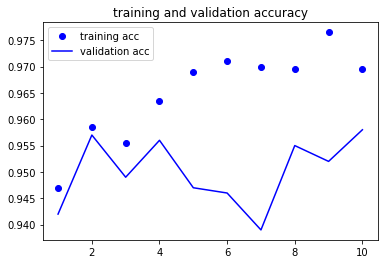

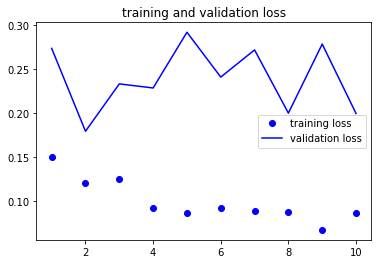

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# For plotting training and validation accuracy
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# For plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [13]:

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

model_fname = 'cats_and_dogs_small_Fine_tuning.h5' 
model.save(model_fname)

Validation loss: 0.1964130501783802
Validation accuracy: 0.9629999959468841


**Problem 3**

In [0]:
model_fname = 'cats_and_dogs_small_Fine_tuning.h5' 

model = load_model(model_fname)
model.load_weights(model_fname)

last_conv_layer = model.get_layer('block5_conv4')

Found 1000 images belonging to 2 classes.


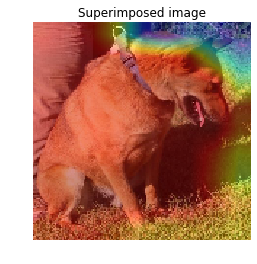

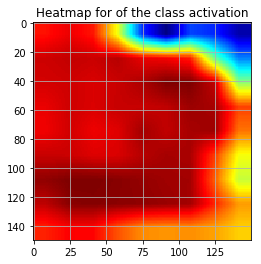

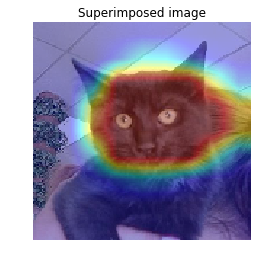

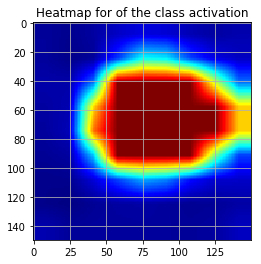

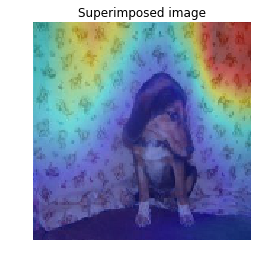

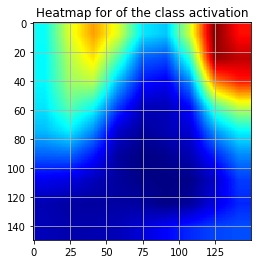

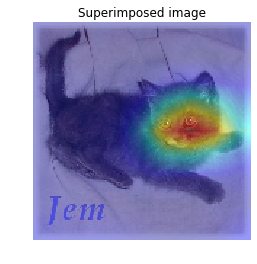

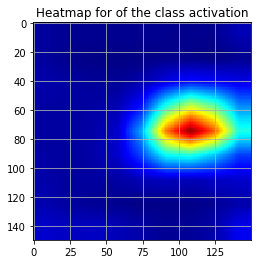

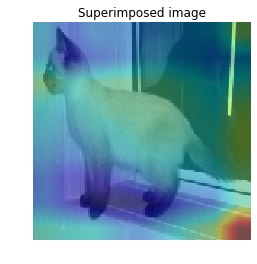

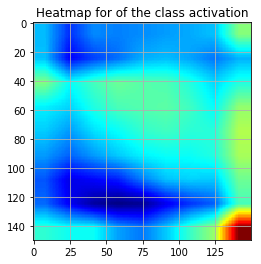

In [15]:
# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
images, labels = next(validation_generator)

## Plot the heatmaps for 5 images
for i in range(5):
  
  img = images[i]
  
  ## Calculate the gradient
  grads = K.gradients(model.output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0], model.output[0]])

  x = np.expand_dims(img, axis=0)
  pooled_grads_value, conv_layer_output_value, preds = iterate([x])

  ## If it is CAT, then the output value will be too low. So we need to subtract it from "1"
  if preds[0] < 0.5:
      conv_layer_output_value = 1-conv_layer_output_value 

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
   
  ## Normalize it  
  heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  ## Rescale it
  superimposed_img =np.uint8(heatmap * 0.4 + np.uint8(255 * img) * 0.6)
 
  
  ## Plot the image with heatmaps
  plt.title("{}".format("Superimposed image"))
  plt.imshow(superimposed_img)
  plt.axis('off')
  plt.grid(None)
  plt.show()

  ## Plot the heatmaps
  plt.title("{}".format("Heatmap for of the class activation"))
  plt.imshow(heatmap)
  plt.grid(None)
  plt.show()

**Problem 4**

Found 1000 images belonging to 2 classes.
Distribution of input data according to their label


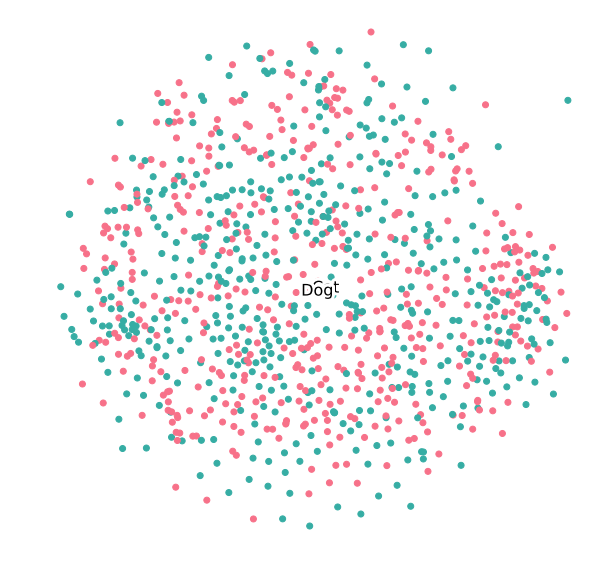

In [20]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        #txt = ax.text(x_coord, y_coord, str(idx), fontsize=16)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])
        

# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')
images, labels = next(validation_generator)

## t-SNE visualization
class_names = ["Cat", "Dog"]
input_t_SNE = TSNE(random_state=42).fit_transform(np.reshape(images,(1000,150*150*3)))
print("Distribution of input data according to their label")
data_scatter(input_t_SNE, labels)

Found 1000 images belonging to 2 classes.


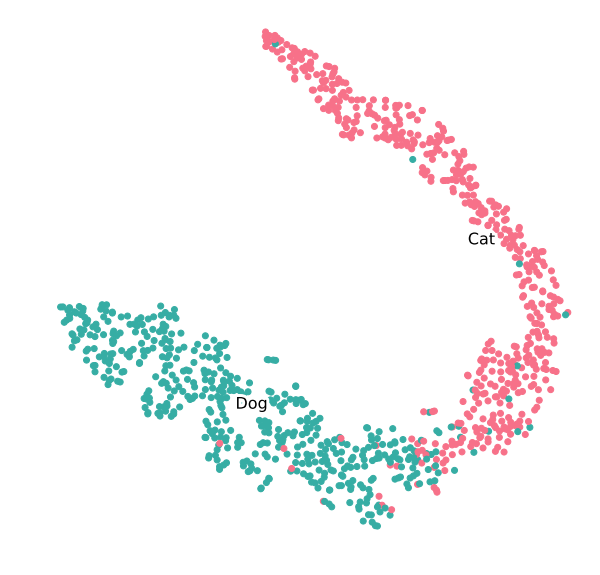

In [18]:
## take the output of the penultimate layer(dense layer)
last_layer = model.get_layer('dense_1')

## BUild the activation model using the last convolution layer of our network
activation_model = models.Model(inputs=model.input, outputs=[last_layer.output])


## Import the validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')
images, labels = next(validation_generator)

## predict the labels
activations = activation_model.predict(images)

last_tsne = TSNE(random_state=42).fit_transform(activations)
class_names = ["Cat", "Dog"]
data_scatter(last_tsne, labels)

Found 1000 images belonging to 2 classes.
Classification after the Convnet


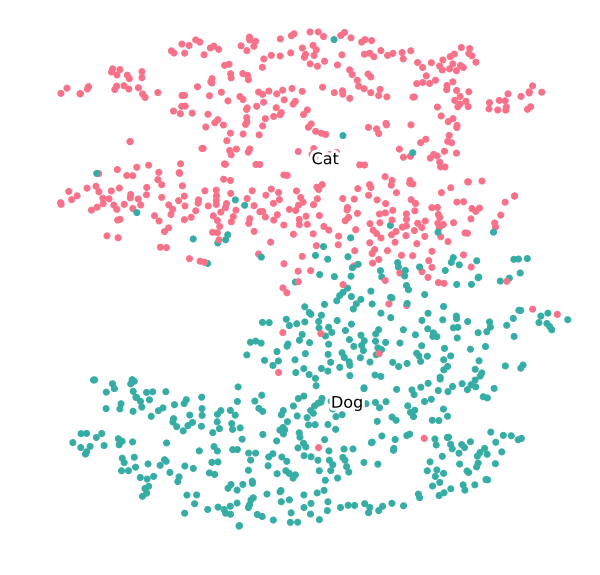

In [19]:
## Output of the convnet(flattened since it works only for 2-dimensional data)
last_layer = model.get_layer('flatten_1')

## BUild the activation model using the last convolution layer of our network
activation_model = models.Model(inputs=model.input, outputs=[last_layer.output])


## Import the validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')
images, labels = next(validation_generator)

activations = activation_model.predict(images)

last_tsne = TSNE(random_state=42).fit_transform(activations)
class_names = ["Cat", "Dog"]
print("Classification after the Convnet")
data_scatter(last_tsne, labels)